In [153]:
import pandas as pd
import numpy as np
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline

In [25]:
import timeit

start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)  

Time:  2.9142946004867554e-05


In [ ]:
## Total reads
A0261917PRE-05 924294624
A017381552 1035986016
DL19032527 883429320
A0260122S1 926730640
A017381552 968891748
A0261917HP4-05 1006874304
DL19032524 1007500512
A017381551 1025309296
A017383551 915443336
A017383552 1029710980
A031438301 1136164988
A017383651 1293457964

In [62]:
import pandas as pd
import pysam
import os
from pybedtools import *

In [2]:
def Output_STATs_after_MAPQ(_input, _MAPQ):
    sam_col = ["QNAME","FLAG","RNAME","POS","MAPQ","CIGAR","MRNM","MPOS","TLEN","SEQ","QUAL","OPT", 13,14,15,16]
    df = pd.read_csv(_input, sep='\t',comment='#', dtype=str, names=sam_col)
    df = df[df.MAPQ.astype(int)==_MAPQ]
    df_tem = pd.DataFrame(data=df.RNAME.str.split("_", expand=True).iloc[:, [0,1]]).rename( columns={0:"GNAME", 1:"chr"})
    df_report = pd.DataFrame(data=df_tem.GNAME.value_counts()).reset_index()
    df_genome_report = df_genome.merge(df_report, on='index', how='outer').fillna(0)
    df_genome_report.to_csv(_input[:-4]+".MAPQ"+str(_MAPQ)+".STATs", sep='\t', index=None)
    return df_genome_report.loc[:, ['GNAME']]#.set_index('index')

def histgram(_input_data, _nbins, _label):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1) 
    plt.hist(_input_data, bins =_nbins, color = ['blue'], label= _label)
    plt.legend()
    plt.xlabel(_label, fontsize=18)
    ax.tick_params(axis='x',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='major', direction='out', length=6, labelsize=18, width=1.5)
    
    return None   

In [5]:
def Filter_sam_mapQ(_Input_Path, _dat_type, _MAPQ):
    PATH_INPUT = _Input_Path
    if (_dat_type=='sam'):
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'r')
    elif (_dat_type=='bam'):
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'rb')
    else: 
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'rc')
    bam_it = imported.fetch(until_eof = True)
    
    STATS=[]
    for read in bam_it:
        STATS.append([read.mapping_quality, read.reference_name])
    df = pd.DataFrame(data=STATS, columns=['MAPQ', 'RNAME'])

    df_genome = pd.read_csv('Genome_Rank.txt', sep='\t',header=None, names=['index','size'])
    df = df[df.MAPQ.astype(int)>=_MAPQ]
    df_tem = pd.DataFrame(data=df.RNAME.str.split("_", expand=True).iloc[:, [0,1]]).rename( columns={0:"GNAME", 1:"chr"})
    df_report = pd.DataFrame(data=df_tem.GNAME.value_counts()).reset_index()
    df_genome_report = df_genome.merge(df_report, on='index', how='outer').fillna(0)
    
    return df_genome_report.loc[:, ['index','GNAME']].set_index('index')

FILE_TYPE = "bam"
Search_PATH= "./"
df_sum = pd.DataFrame()
for file in os.listdir(Search_PATH):
    if file.endswith(FILE_TYPE):
        df_tem = Filter_sam_mapQ(file,FILE_TYPE, 60).rename(columns={'GNAME':file[:-4]})
        df_sum = pd.concat( [df_sum, df_tem] , axis=1)
df_sum = df_sum.fillna(0).astype(int).drop(['wuhCor1','Hg38', 'dm6', 'Dm6', 'sacCer3'], axis=0)

df_sum.loc['sum',:] = df_sum.sum(axis=0)
df_sum = df_sum.loc[:, ['DL19032524','A017381552','A017381551', 'A0260122S1','DL19032527',
 'A0186048MMC-02', 'A0261917HP4-05', 'A0261917PRE-05', 'A031438301', 
 'A017383551', 'A017383552',  'A017383651']].astype(int)
#df_sum.to_csv("8_samples.stats", sep='\t')

df_sum=df_sum.drop(['wuhCor1','Hg38', 'dm6', 'Dm6', 'sacCer3'], axis=0)
df_sum.style\
    .apply(lambda x: [ "background: yellow" if v > 100 else "" for v in x], axis = 1)\
    .format('{:,}')\
    .set_properties(**{
    'font-size': '14pt',
})

In [26]:
## FLAG
#1 0x1 template having multiple segments in sequencing
#2 0x2 each segment properly aligned according to the aligner
#4 0x4 segment unmapped
#8 0x8 next segment in the template unmapped
#16 0x10 SEQ being reverse complemented
#32 0x20 SEQ of the next segment in the template being reverse complemented
#64 0x40 the first segment in the template
#128 0x80 the last segment in the template
#256 0x100 secondary alignment
#512 0x200 not passing filters, such as platform/vendor quality controls
#1024 0x400 PCR or optical duplicate
#2048 0x800 supplementary alignment

In [101]:
def Read_sam(_Input_Path, _dat_type):
    PATH_INPUT = _Input_Path
    if (_dat_type=='sam'):
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'r')
    elif (_dat_type=='bam'):
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'rb')
    else: 
        imported = pysam.AlignmentFile(PATH_INPUT, mode = 'rc')
    bam_it = imported.fetch(until_eof = True)
    
    STATS=[]
    for read in bam_it:
        STATS.append([read.flag, read.mapping_quality, read.reference_name])
    return pd.DataFrame(data=STATS, columns=['FLAG','MAPQ', 'RNAME'])

FILE_TYPE = "bam"
Search_PATH= "./"
df_feature = pd.read_csv("./Omni1.0_panel.bed", sep='\t', skiprows=1,header=None)
Feature_Target = BedTool.from_dataframe(df_feature)

MAPQ=1
    
Search_PATH="/ghess/groups/algorithms/projects/non_human_contamination/test_sample_cram/Output/BWA_Results/dev_stats/BWA_Results/hg/"
STATS=[]
for file in os.listdir(Search_PATH):
    if file.endswith(FILE_TYPE):
        #print(file)
        Feature_reads_bam = example_bedtool(Search_PATH+file)
        Feature_reads = Feature_reads_bam.bam_to_bed(stream=False)
        df_reads = pd.read_csv(Feature_reads.fn, sep='\t' , header=None)
        Feature_reads_60 = BedTool.from_dataframe(df_reads[df_reads[4]>=MAPQ])
        df_tem = Read_sam(Search_PATH+file, FILE_TYPE).rename(columns={'GNAME':file[:-4]})
        
        Num_nonhg = len(df_tem[df_tem.MAPQ>=MAPQ])
        Num_nonmap = len(df_tem) - Num_nonhg
        num_on_target = len(Feature_reads_60.intersect(Feature_Target, u=True))
        num_off_target = len(Feature_reads_60.intersect(Feature_Target, v=True))
        STATS.append([file[:-4], Num_nonmap, Num_nonhg, num_on_target, num_off_target])
        #break
df_sum = pd.DataFrame(data=STATS, columns=['NAME', 'no mapped','non-hg',  'on-target', 'off-target'])
df_sum

,NAME,no mapped,non-hg,on-target,off-target
0,A017383552,209,81,29,52
1,A0261917PRE-05,256,129,56,73
2,A017383551,261,106,14,92
3,A0261917HP4-05,297,141,54,87
4,DL19032527,4139,7243,6621,622
5,A031438301,2920,770,424,346
6,A0260122S1,8015,10797,9818,979
7,A017383651,178,73,17,56
8,A017381551,26769,12739,11534,1205
9,DL19032524,36680,41890,38557,3333


In [5]:
import os

In [42]:
import pandas as pd
def Output_STATs_after_MAPQ(_input, _MAPQ):
    ## Reference
    df_genome = pd.read_csv('Genome_Rank.txt', sep='\t',header=None, names=['index','size'])
    sam_col = ["QNAME","FLAG","RNAME","POS","MAPQ","CIGAR","MRNM","MPOS","TLEN","SEQ","QUAL","OPT", 13,14,15,16]
    df = pd.read_csv(_input, sep='\t',comment='#', dtype=str, names=sam_col)
    df = df[df.MAPQ.astype(int)==_MAPQ]
    df_tem = pd.DataFrame(data=df.RNAME.str.split("_", expand=True).iloc[:, [0,1]]).rename( columns={0:"GNAME", 1:"chr"})
    df_report = pd.DataFrame(data=df_tem.GNAME.value_counts()).reset_index()
    df_genome_report = df_genome.merge(df_report, on='index', how='outer').fillna(0)
    #df_genome_report.to_csv(_input[:-4]+".MAPQ"+str(_MAPQ)+".STATs", sep='\t', index=None)
    return df_genome_report.loc[:, ['index','GNAME']].set_index('index')
#Output_STATs_after_MAPQ("DL19032524.sam.nonhg38.sam", 60)

os.chdir('/ghess/groups/algorithms/projects/non_human_contamination/test_sample_cram/Output/BWA_Results/dev_stats')
FILE_SAM = ["A0261917HP4-05.sam", "A0261917PRE-05.sam", "DL19032527.sam", "A0186048MMC-02.sam", "A0260122S1.sam"]
df_sum = pd.DataFrame()
for sam_f in FILE_SAM:
    print (sam_f)
    df_tem = Output_STATs_after_MAPQ(sam_f, 60).rename(columns={'GNAME':sam_f[:-4]})
    df_sum = pd.concat( [df_sum,df_tem] , axis=1)

In [13]:
InSamFile = 'A0260122S1.sam'
_MAPQ=60
sam_col = ["QNAME","FLAG","RNAME","POS","MAPQ","CIGAR","MRNM","MPOS","TLEN","SEQ","QUAL","OPT", 13,14,15,16]
df = pd.read_csv(InSamFile, sep='\t',comment='#', dtype=str, names=sam_col)
#iter_sam = pd.read_csv(InSamFile, iterator=True, chunksize=10, sep='\t',comment='#', dtype=str, names=sam_col)
#df = pd.concat([chunk[chunk["MAPQ"] == _MAPQ] for chunk in iter_sam])
#df

,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR,MRNM,MPOS,TLEN,SEQ,QUAL,OPT,13,14,15,16
0,A00274:333:HF7M5DSXY:4:2371:31991:5760:N:0:GAT...,0,oryCun2_chrUn0041,1237004,25,9M3I11M3D51M,*,0,0,GAGGAGGGAGGGGGAGGGAGGAGGGAGGGAGGAGGGAGGAGGGAGG...,"FFFFFFFFFFFFFFFFFFFFFFFFF,:FFFFFFFFFFFFFFFFFFF...",NM:i:6,MD:Z:20^GGA51,AS:i:53,XS:i:42,NaN
1,A00274:333:HF7M5DSXY:3:1629:16559:31391:N:0:GA...,16,mm39_chr11,30508864,10,57M9S,*,0,0,CCCCCTCCCCCTCCCCCTCCCCCTCCTCCTCCCCCCTCCCCCTCCC...,:FFFFFFFFF:F:F:FFFF:FFFFFFFFFFFFFFFFFFFFFFFFFF...,NM:i:1,MD:Z:8T48,AS:i:52,XS:i:47,"XA:Z:canFam5_chr15,-44634498,12S25M1D29M,1;ory..."
2,A00274:333:HF7M5DSXY:3:1211:4246:5118:N:0:GATC...,16,rn7_chr2,218151333,17,10S33M8S,*,0,0,CTCTCCCTCTCCCCCTCCCCCCCCCCTCCCCCCCTCTCTCCCTTCC...,"FF,FFFFF:F:FFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFF...",NM:i:0,MD:Z:33,AS:i:33,XS:i:28,NaN
3,A00274:333:HF7M5DSXY:3:2457:8910:28134:N:0:GAT...,0,galGal6_chr3,96526702,18,82S61M,*,0,0,CCCTTCCTACCACACCCCCCCCACCCCCCCCACAACAAACACACAA...,",:,FFFF:,,F:F,,:::FF,:,,,FF:,,F:,,,,,,,::F,:,,...",NM:i:1,MD:Z:9C51,AS:i:56,XS:i:49,NaN
4,A00274:333:HF7M5DSXY:3:1313:11279:18051:N:0:GA...,0,oryCun2_chr6,6478164,11,13S15M1I32M10S,*,0,0,AGAGGGAGGAAGGGGGAGGGAGGGAGGGAAGAGAAGGAGGGAGGGA...,"F:F,FFFFFFF:FFFFF::FF::FFFFFFF:F:FFFFF:,:F,FFF...",NM:i:1,MD:Z:47,AS:i:40,XS:i:36,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99129,A00274:333:HF7M5DSXY:2:1404:2537:32816:N:0:GAT...,0,mm39_chr14,78485843,18,42M2S,*,0,0,GGGGGAGGGGGAGGGGAGGGGGAGGAGAGAGGAGGGGAGGGGAG,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,NM:i:1,MD:Z:29G12,AS:i:37,XS:i:32,NaN
99130,A00274:333:HF7M5DSXY:2:2273:21811:5791:N:0:GAT...,16,mm39_chr10,70249506,11,46M,*,0,0,CCTCCCCTCCCCTCTCCCCTCCCCCCTCCCCCCTCCCCTCCCCTCC,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,NM:i:1,MD:Z:12C33,AS:i:41,XS:i:37,NaN
99131,A00274:333:HF7M5DSXY:2:2553:31973:13745:N:0:GA...,0,galGal6_chr1,100457328,15,54M20S,*,0,0,GGGAGGGGAGGGGAGGGGAGGGGAGGCCAGGGGAGGGGAGGGGAGG...,":FFFFFFFFF:FFF:FFFF:F,FFFFFFF:FF,F,:FFFF,,FF,:...",NM:i:2,MD:Z:26G0G26,AS:i:44,XS:i:38,"XA:Z:felCat9_chrD3,-21049373,16S48M10S,2;"
99132,A00274:333:HF7M5DSXY:1:1566:8395:17942:N:0:GAT...,0,felCat9_chrA1,240656198,13,11M4I4M3D23M1I4M2D63M33S,*,0,0,GGAGGGGGAGGGGAAAGGGGGAGGGGGAGGAGGGGTAGAAGGAGGG...,FFFFFFFF:FFFFFFFFFFFFF:FFFF:FFFFFFF:FFFFFFFFF:...,NM:i:13,MD:Z:15^GGA16G2G7^GG3G59,AS:i:60,XS:i:52,"SA:Z:rn7_chr3,39244337,-,9M1I24M5D14M2I13M80S,..."


In [15]:
InSamFile = 'A0260122S1.sam'
sam_col = ["QNAME","FLAG","RNAME","POS","MAPQ","CIGAR","MRNM","MPOS","TLEN","SEQ","QUAL","OPT", 13,14,15,16]
df = pd.read_csv(InSamFile, sep='\t',comment='#', dtype=str, names=sam_col)
df = df[df.MAPQ.astype(int)==60]
df.head()

df = df[df.MAPQ.astype(int)==60]
df_tem = pd.DataFrame(data=df.RNAME.str.split("_", expand=True).iloc[:, [0,1]]).rename( columns={0:"GNAME", 1:"chr"})
df_report = pd.DataFrame(data=df_tem.GNAME.value_counts()).reset_index()
#df_genome.merge(df_report, on='index', how='outer').fillna(0)

In [19]:
import pysam
## read from pysam
samfile = pysam.AlignmentFile("test.sam", "r", check_sq=False)
for read in samfile.fetch():
    #print (read)
    break

samfile.close()

In [3]:
os.listdir()

['test.sam',
 'DL19032524.sam.nonhg38.sam',
 'DL19032524_H_sorted.bam',
 '.ipynb_checkpoints',
 'DL19032524.sam',
 'Sam_parser.ipynb',
 'chr_STATs.log']

In [141]:
#Output_STATs_after_MAPQ("DL19032524.sam.nonhg38.sam", 60)

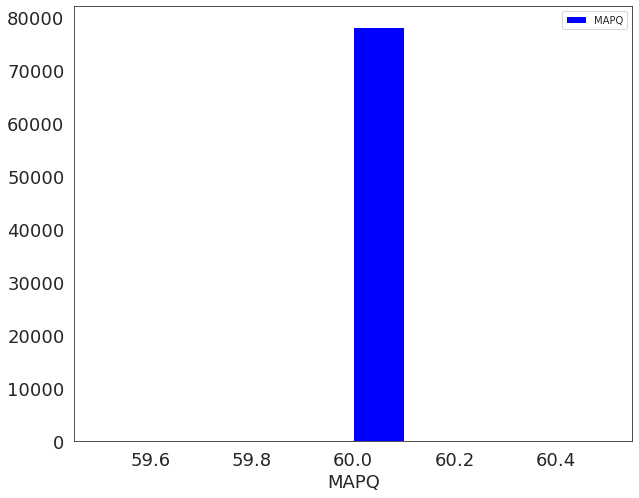

In [139]:
histgram(df.MAPQ.astype(int), 10, 'MAPQ')   